## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

True

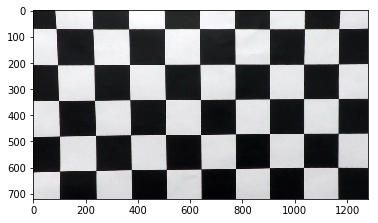

In [36]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def calcCameraCalibrationPoints():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    return objpoints, imgpoints

img = cv2.imread('./camera_cal/calibration1.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
objpoints, imgpoints=calcCameraCalibrationPoints()
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

#Test output

dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(dst)
cv2.imwrite('./output_images/calibration1_undistort.jpg', dst)

## Apply distortion correction to raw images

In [37]:
import os

img=cv2.imread('./test_images/straight_lines1.jpg')
undistorted=cv2.undistort(img, mtx, dist, None, mtx)


## Create threshold binary image

In [38]:
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    sobelx=cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely=cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobelxy=np.sqrt((sobelx*sobelx) + (sobely*sobely))
    abs_sobelx = np.absolute(sobelxy)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return sxbinary

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    #gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    sobeldir=np.arctan2(abs_sobely, abs_sobelx)
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    #scaled_sobel = np.uint8(255*sobeldir/np.max(sobeldir))
    sxbinary = np.zeros_like(sobeldir)
    sxbinary[(sobeldir >= thresh[0]) & (sobeldir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(sxbinary) # Remove this line
    return binary_output

def abs_sobel_thresh(gray, orient='x', thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    sobelxx=0
    if orient=='x':
        sobelxx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobelxx = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobelx = np.absolute(sobelxx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary


def thresholdImage(img, s_thresh=(80, 255), sx_thresh=(20, 100), sobel_kernel=3):
    # R chanel from RGB
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    
    # Convert to HLS color space
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Convert to HSV color space
    # Note: img is the undistorted image
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv1_channel = hsv[:,:,0]
    hsv2_channel = hsv[:,:,1]
    hsv3_channel = hsv[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', thresh=(20, 100))
    grady = abs_sobel_thresh(gray, orient='y', thresh=(20, 100))
    
    # Magnitude and direction
    mag_binary = mag_thresh(gray, mag_thresh=(30, 100))
    dir_binary = dir_threshold(gray,sobel_kernel=15, thresh=(0.7, 1.3))
    
    # Combine sobelx, magnitude and direction
    sobel_combined = np.zeros_like(dir_binary)
    sobel_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    # Threshold white line
    r_thresh = (180, 255)
    g_thresh = (180, 255)
    b_thresh = (180, 255)
    wl_thres = (200, 255)
    wl_binary = np.zeros_like(R)
    wl_binary[(R > r_thresh[0]) & (R <= r_thresh[1]) & (G > g_thresh[0]) & (G <= g_thresh[1]) & 
               (B > b_thresh[0]) & (B <= b_thresh[1]) & (l_channel > wl_thres[0]) & (l_channel <= wl_thres[1])] = 1
    
    # Threshold yellow line
    ys_thresh = (100, 255)
    yh_thresh = (10, 80)
    yl_binary = np.zeros_like(R)
    yl_binary[(s_channel > ys_thresh[0]) & (s_channel <= ys_thresh[1]) #& 
              #(h_channel > yh_thresh[0]) & (h_channel <= yh_thresh[1])
             ] = 1
    
    # Threshold S channel
    #s_binary = np.zeros_like(s_channel)
    #s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold L channel
    #l_thresh = (80, 255)
    #l_binary = np.zeros_like(l_channel)
    #l_binary[(s_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(s_channel)
    combined_binary[((wl_binary == 1) | (yl_binary==1)) | (sobel_combined == 1)] = 1 #| (sobel_combined == 1)] = 1
    #return combined_binary
    return combined_binary


binaryimg =thresholdImage(undistorted)

## Apply perspective transformation

In [39]:
import matplotlib.image as mpimg

def warper(gray, src, dst):
    img_size = (binaryimg.shape[1], binaryimg.shape[0])
    M=cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(gray, M, img_size)
    return warped, M

img_size = (binaryimg.shape[1], binaryimg.shape[0])
src = np.float32(
        [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
        [((img_size[0] / 6) + 5), img_size[1]],
       [(img_size[0] * 5 / 6) + 40, img_size[1]],
        [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])
dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

top_down, perspective_M =warper(binaryimg, src, dst)

## Use sliding window to detect line pixel

In [40]:
def find_lane_pixels(binary_warped, doplot):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped, doplot=0):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, doplot)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    if(doplot):
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

    return out_img, ploty, left_fit, right_fit, lefty, righty, leftx, rightx, left_fitx, right_fitx



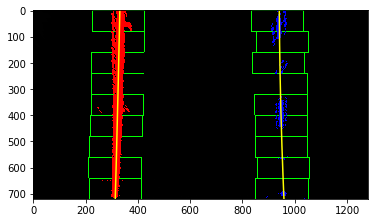

In [41]:
out_img, ploty, left_fit, right_fit, lefty, righty, leftx, rightx, left_fitx, right_fitx = fit_polynomial(top_down, 1)
plt.imshow(out_img)

## Determine the curvature of the lane

In [42]:
def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    
    return left_curverad, right_curverad

left_cr, right_cr = measure_curvature_pixels(ploty, left_fit, right_fit)
print(left_cr, right_cr)

90120.5107287 19683.7543619


## Transform curvature from pixel to real world

In [43]:
def measure_curvature_real(ploty, leftx,lefty, rightx, righty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.0/100 # meters per pixel in y dimension
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    #ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad, left_fit_cr[2] - (xm_per_pix*640), right_fit_cr[2] - (xm_per_pix*640)

# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad, offset_left, offset_right = measure_curvature_real(ploty, leftx, lefty, rightx, righty)

print(left_curverad, 'm', right_curverad, 'm', offset_left, 'm', offset_right, 'm')

14076.9347538 m 3315.77210918 m -1.78551757841 m 1.73909187325 m


## Transform curvation to real world

True

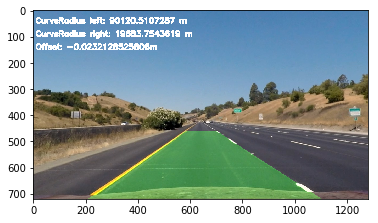

In [44]:
def PutTextToImage(img, l_cr, r_cr, offset):
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    position_l               = (10,50)
    position_r               = (10,100)
    position_o               = (10,150)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 5
    text='CurveRadius left: ' + str(l_cr) + ' m'
    text2='CurveRadius right: ' + str(r_cr) + ' m'
    text3='Offset: ' + str(offset) + 'm'
    cv2.putText(img,text, 
        position_l, 
        font, 
        fontScale,
        fontColor,
        lineType)
    cv2.putText(img,text2, 
        position_r, 
        font, 
        fontScale,
        fontColor,
        lineType)
    cv2.putText(img,text3, 
        position_o, 
        font, 
        fontScale,
        fontColor,
        lineType)

def transformRealWorld(top_down, left_fitx, right_fitx, ploty, dst, src, undist):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(top_down).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv=cv2.getPerspectiveTransform(dst, src)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

resultimg=transformRealWorld(top_down, left_fitx, right_fitx, ploty, dst, src, undistorted)
PutTextToImage(resultimg, left_cr, right_cr, (offset_right+offset_left)/2)
plt.imshow(cv2.cvtColor(resultimg, cv2.COLOR_RGB2BGR))
cv2.imwrite('./output_images/warped_back_lines.jpg', resultimg)

## Pipeline

In [52]:
def ProcessImageR(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
        [((img_size[0] / 6) + 5), img_size[1]],
       [(img_size[0] * 5 / 6) + 40, img_size[1]],
        [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    return ProcessImage(img, mtx, dist, src, dst)

def ProcessImage(img, mtx, dist, src, dst):
    undistorted=cv2.undistort(img, mtx, dist, None, mtx)
    binaryimg =thresholdImage(undistorted)
    #cv2.imwrite('./output_images/binary_test1.jpg',binaryimg*255)
    top_down, perspective_M =warper(binaryimg, src, dst)
    out_img, ploty, left_fit, right_fit, lefty, righty, leftx, rightx, left_fitx, right_fitx = fit_polynomial(top_down, 0)
    left_cr, right_cr = measure_curvature_pixels(ploty, left_fit, right_fit)
    left_curverad, right_curverad, offset_left, offset_right = measure_curvature_real(ploty, leftx, lefty, rightx, righty)
    resultimg=transformRealWorld(top_down, left_fitx, right_fitx, ploty, dst, src, undistorted)
    #PutTextToImage(resultimg, left_cr, right_cr, (offset_right+offset_left)/2)
    #b_zero = np.zeros_like(binaryimg).astype(np.uint8)
    #col=np.dstack((binaryimg*255, b_zero, b_zero))
    return resultimg

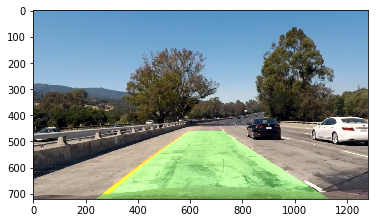

In [53]:
#Test Pipeline
img=cv2.imread('./test_images/test1.jpg')
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))#ProcessImageR(img))
plt.imshow(cv2.cvtColor(ProcessImageR(img), cv2.COLOR_RGB2BGR))#ProcessImageR(img))

## Test on video

In [54]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = './challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip('./challenge_video.mp4') #.subclip(2,4)
video_clip = clip1.fl_image(ProcessImageR) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./challenge_video_output.mp4
[MoviePy] Writing video ./challenge_video_output.mp4


100%|██████████| 485/485 [03:48<00:00,  2.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./challenge_video_output.mp4 

CPU times: user 2min 59s, sys: 1.09 s, total: 3min
Wall time: 3min 51s


In [55]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))